In [ ]:
# DOWNLOAD USING KAGGLE

# !chmod 600 /content/kaggle.json
# !mv /content/kaggle.json /root/.kaggle/kaggle.json
# !kaggle competitions download flowerdata-module5

In [ ]:
# OR INFLATING DATA FROM DRIVE

# !unzip "/content/drive/MyDrive/Uni/flowerdata-module5.zip" -d "/content/data/"

In [ ]:
!pip install -q efficientnet

In [ ]:
!pip install kaggledatasets

In [ ]:
from PIL import Image
from torchvision import transforms
import torchvision
from IPython.display import clear_output
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
import math, re, gc
import numpy as np # linear algebra
import pickle
from datetime import datetime, timedelta
import tensorflow as tf
import efficientnet.tfkeras as efficientnet
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print('TensorFlow version', tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split


TensorFlow version 2.7.0


# INITIAL SETUP

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Replicas:', strategy.num_replicas_in_sync)

Replicas: 1


In [ ]:
IMAGE_SIZE = [512, 512] # [512, 512]

EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# HELPER FUNCTIONS

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# PREPARE DATA

In [ ]:
N_CLASSES = 102
TRAIN_FILES_PATH = '/content/data/train/train/'
TEST_FILES_PATH = '/content/data/test/test'

# Let's start from X (links to pictures)
# Training filenames
TRAINING_FILENAMES = []
for label in range(1,N_CLASSES+1):
    TRAINING_FILENAMES.extend(
        tf.io.gfile.glob(TRAIN_FILES_PATH + f'{label}' + '/*.jpg')
        )

# Continue with Y (labels)
TRAINING_LABELS = []
for link_to_file in TRAINING_FILENAMES:
    TRAINING_LABELS.append(
        re.findall("\/\d*\/", link_to_file)[0] \
            .replace("/", "")
    )


# Test filenames (to predict and submit)
TEST_FILENAMES = tf.io.gfile.glob(TEST_FILES_PATH + '/*.jpg')

# Validation filenames
TRAIN_FILENAMES, VALID_FILENAMES, TRAIN_LABELS, VALID_LABELS = train_test_split(
    TRAINING_FILENAMES, TRAINING_LABELS, 
    train_size=0.8, 
    random_state=42,
    stratify=TRAINING_LABELS
    )

print(f"Количество строк в TRAIN_LABELS по классам: {np.bincount(TRAIN_LABELS)}")
print(f"Количество строк в VALID_LABELS по классам: {np.bincount(VALID_LABELS)}")

In [ ]:
NUM_TRAINING_IMAGES = len(TRAIN_FILENAMES)
NUM_VALIDATION_IMAGES = len(VALID_FILENAMES)
NUM_TEST_IMAGES = len(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 5241 training images, 1311 validation images, 818 unlabeled test images


In [ ]:
assert(len(TRAIN_FILENAMES) == len(TRAIN_LABELS))
assert(len(VALID_FILENAMES) == len(VALID_LABELS))

### Prepare Train Dataset class

In [ ]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomRotation((-30,30)),
        # transforms.RandomGrayscale(p=0.2),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.RandomInvert(p=0.2),
        transforms.RandomAutocontrast(p=0.2),
        transforms.ColorJitter(contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

class TrainValidDataset(torch.utils.data.Dataset):
  def __init__(self, image_paths,
               transforms,
               labels):
    self.image_paths = image_paths
    self.transforms = transforms
    self.labels = labels

  def __len__(self):
    return(len(self.image_paths))

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx])
    image = self.transforms(image)
    category = self.labels[idx]
    return (torch.FloatTensor(image), torch.tensor(int(category)))

TRAIN_DATA = TrainValidDataset(image_paths=TRAIN_FILENAMES,
                          transforms = train_transforms,
                          labels=TRAIN_LABELS)
TRAIN_LOADER = torch.utils.data.DataLoader(TRAIN_DATA, batch_size=2,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


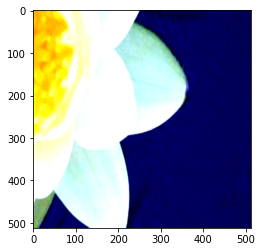

In [ ]:
imgs, categories = next(iter(TRAIN_LOADER))
imshow(imgs[0])

### Prepare Validation dataset

In [ ]:
valid_transforms = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

VALID_DATA = TrainValidDataset(image_paths=VALID_FILENAMES,
                          transforms = valid_transforms,
                          labels=VALID_LABELS)
VALID_LOADER = torch.utils.data.DataLoader(VALID_DATA, batch_size=2,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


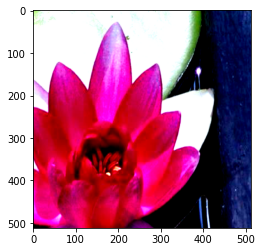

In [ ]:
imgs, categories = next(iter(VALID_LOADER))
imshow(imgs[0])

### Prepare Test Dataset Class

In [ ]:
test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

class TestDataset(torch.utils.data.Dataset):
  def __init__(self, image_paths,
               transforms):
    self.image_paths = image_paths
    self.transforms = transforms

  def __len__(self):
    return(len(self.image_paths))

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx])
    image = self.transforms(image)
    return torch.FloatTensor(image)

TEST_DATA = TestDataset(image_paths=TEST_FILENAMES,
                          transforms = test_transforms)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATA, batch_size=2,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


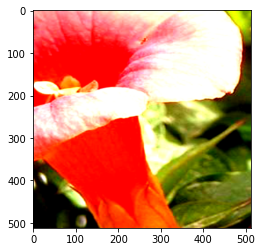

In [ ]:
imgs = next(iter(TEST_LOADER))
imshow(imgs[0])

# Train process

Learning rate schedule: 1e-05 to 5e-05 to 1.06e-05


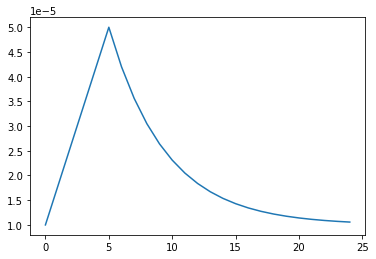

In [ ]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
def lrfn1(epoch):
    return LR_START

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
class TimeCallback(torch.utils.Callback): #tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if((datetime.now() - start_time).total_seconds() > 9500):
            self.model.stop_training = True
            
time_callback = TimeCallback()

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

In [ ]:
def train(seed, epochs, model):
    
  print('Creating a model {}...'.format(seed))

  model.to(device)  
  criterion = torch.nn.CrossEntropyLoss()
  if seed==2 or seed==3:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in TRAIN_LOADER[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
          acc = 100. * running_corrects.double() / dataset_sizes[phase]
          scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
        
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)


  model.load_state_dict(best_model)

  for param in model.parameters():
        param.requires_grad=True

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in TRAIN_LOADER[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
        acc = 100. * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

  model.load_state_dict(best_model)
  return model

# Models

In [ ]:
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### DenseNet (1)

In [ ]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = torch.nn.Linear(
    in_features=densenet121_0.classifier.in_features,
    out_features=102,
    bias=True
    )

### DenseNet (2)

In [ ]:
densenet121_1 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_1.parameters():
  param.requires_grad=False

densenet121_1.classifier = torch.nn.Linear(
    in_features=densenet121_1.classifier.in_features,
    out_features=102,
    bias=True)

### GoogleNet

In [ ]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = torch.nn.Linear(
    in_features=googlenet.fc.in_features,
    out_features=102,
    bias=True)

### ResNet

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = torch.nn.Linear(
    in_features=resnet101.fc.in_features,
    out_features=102,
    bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

### VGG19

In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = torch.nn.Linear(
    4096, 102, bias=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
num_models = 5
epochs = 10

models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
   train(seed=seed, epochs=epochs, model=models[seed])

In [ ]:
import pandas as pd

In [ ]:
d = pd.read_csv("submit 2.csv", sep=';')

In [ ]:
d.tail(10)

,Id,Category
808,image_08040.jpg,102
809,image_08041.jpg,102
810,image_08059.jpg,91
811,image_08063.jpg,99
812,image_08067.jpg,31
813,image_08105.jpg,6
814,image_08113.jpg,93
815,image_08145.jpg,57
816,image_08155.jpg,62
817,image_08171.jpg,62


In [ ]:
d.to_csv("submit 2_.csv" , index=False)